# Выбор локации для скважины

Для обеспечения наивысшей рентабильности добывающей компании «ГлавРосГосНефть», нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

## Цель

Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.

## Задачи

-    Построить модель для каждого региона, где ищут месторождения и оцениваем объём запасов.
-    Выбираем месторождения с самым высокими оценками запасов. Количество месторождений будет зависеть от бюджета компании и стоимости разработки одной скважины.
-    Оцениваем прибыль ненфтедобычи, которая равна суммарной прибыли отобранных месторождений.

## Дополнительные условия

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка необходимых библиотек и наборов данных

In [1]:
import warnings
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [2]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None

warnings.filterwarnings("ignore")

In [3]:
try:
    geo0 = pd.read_csv("./geo_data_0.csv")
    geo1 = pd.read_csv("./geo_data_1.csv")
    geo2 = pd.read_csv("./geo_data_2.csv")
except FileNotFoundError:
    geo0 = pd.read_csv("/datasets/geo_data_0.csv")
    geo1 = pd.read_csv("/datasets/geo_data_1.csv")
    geo2 = pd.read_csv("/datasets/geo_data_2.csv")

In [4]:
geo0.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [5]:
geo0.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [6]:
geo1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-5.88e-03,3.18
1,62mP7,14.27,-3.48,9.99e-01,26.95
2,vyE1P,6.26,-5.95,5.00e+00,134.77
3,KcrkZ,-13.08,-11.51,5.00e+00,137.95
4,AHL4O,12.70,-8.15,5.00e+00,134.77


In [7]:
geo1.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [8]:
geo2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [9]:
geo2.describe()

,f0,f1,f2,product
count,1.00e+05,1.00e+05,100000.00,100000.00
mean,2.02e-03,-2.08e-03,2.50,95.00
std,1.73e+00,1.73e+00,3.47,44.75
min,-8.76e+00,-7.08e+00,-11.97,0.00
25%,-1.16e+00,-1.17e+00,0.13,59.45
50%,9.42e-03,-9.48e-03,2.48,94.93
75%,1.16e+00,1.16e+00,4.86,130.60
max,7.24e+00,7.84e+00,16.74,190.03


Пропусков в данных нет, но параметры `f0`, `f1`, `f2` различаются масштабом: среднее значение `f2` во всех регионах около 2,5.  В то же время, дисперсия `f2` меняется от региона к региону в диапазоне [1.7, 3.45]. При этом среднее `f1` лежит в диапазоне [$-2\cdot 10^{-3}$, 2.5], а `f0`&nbsp;&mdash; [$2\cdot 10^{-3}$, 1.14].

Признаки необходимо нормировать.

Разделим данные на тренировочную и валидационную выборки и нормируем.

In [10]:
geo0_X = geo0.drop(["id", "product"], axis=1)
geo1_X = geo1.drop(["id", "product"], axis=1)
geo2_X = geo2.drop(["id", "product"], axis=1)
geo0_y = geo0["product"]
geo1_y = geo1["product"]
geo2_y = geo2["product"]
# geo0_ids = geo0["id"]
# geo1_ids = geo1["id"]
# geo2_ids = geo2["id"]

In [11]:
geo0_X_train, geo0_X_valid, geo0_y_train, geo0_y_valid = train_test_split(
    geo0_X, geo0_y, test_size=0.25, random_state=42
)
geo1_X_train, geo1_X_valid, geo1_y_train, geo1_y_valid = train_test_split(
    geo1_X, geo1_y, test_size=0.25, random_state=42
)
geo2_X_train, geo2_X_valid, geo2_y_train, geo2_y_valid = train_test_split(
    geo2_X, geo2_y, test_size=0.25, random_state=42
)

Прежде чем выбирать метод нормализации данных посмотрим на распределения значений параметров 

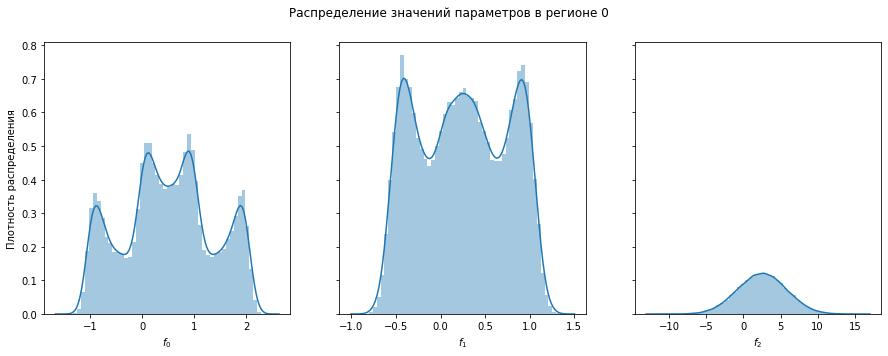

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Распределение значений параметров в регионе 0")
sns.distplot(geo0["f0"], ax=axes[0])
sns.distplot(geo0["f1"], ax=axes[1])
sns.distplot(geo0["f2"], ax=axes[2])
axes[0].set_ylabel("Плотность распределения")
axes[0].set_xlabel(r"$f_0$")
axes[1].set_xlabel(r"$f_1$")
axes[2].set_xlabel(r"$f_2$");

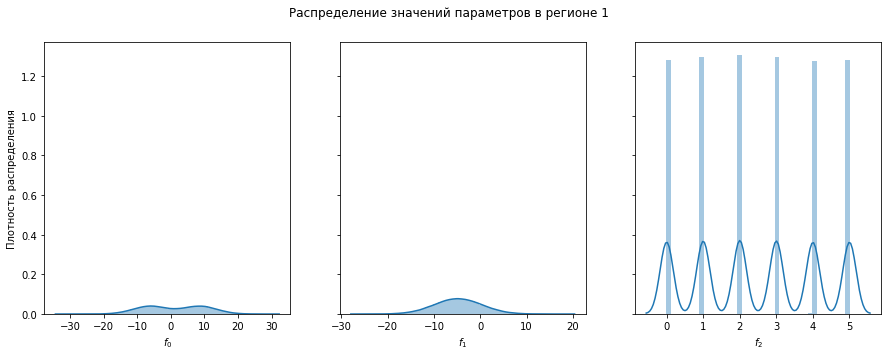

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Распределение значений параметров в регионе 1")
sns.distplot(geo1["f0"], ax=axes[0])
sns.distplot(geo1["f1"], ax=axes[1])
sns.distplot(geo1["f2"], ax=axes[2])
axes[0].set_ylabel("Плотность распределения")
axes[0].set_xlabel(r"$f_0$")
axes[1].set_xlabel(r"$f_1$")
axes[2].set_xlabel(r"$f_2$");

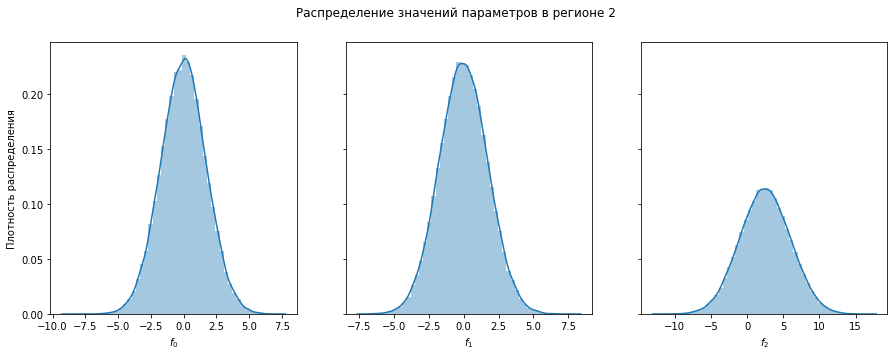

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Распределение значений параметров в регионе 2")
sns.distplot(geo2["f0"], ax=axes[0])
sns.distplot(geo2["f1"], ax=axes[1])
sns.distplot(geo2["f2"], ax=axes[2])
axes[0].set_ylabel("Плотность распределения")
axes[0].set_xlabel(r"$f_0$")
axes[1].set_xlabel(r"$f_1$")
axes[2].set_xlabel(r"$f_2$");

Видно, что в регионе 2 параметры распределены более-менее по Гауссу, в остальных&nbsp;&mdash; приблизительно колоколообразно, хотя и мультимодально. Это означаеть, что с одной стороны сложно говорить о дисперсии в классическом понимании, с другой&nbsp;&mdash; значения имеют хвосты, а стало быть потенциально не ограничены предопрееделёнными значениями [min, max]. 

В этой ситуации более предпочтительной видится процедура стандартизации данных: сведение их к значениям с нулевым средним и единичной дисперсией.  

In [15]:
scaler = StandardScaler()

In [16]:
scaler.fit(geo0_X_train)
geo0_X_train[["f0", "f1", "f2"]] = scaler.transform(geo0_X_train)
geo0_X_valid[["f0", "f1", "f2"]] = scaler.transform(geo0_X_valid)

In [17]:
scaler.fit(geo1_X_train)
geo1_X_train[["f0", "f1", "f2"]] = scaler.transform(geo1_X_train)
geo1_X_valid[["f0", "f1", "f2"]] = scaler.transform(geo1_X_valid)

In [18]:
scaler.fit(geo2_X_train)
geo2_X_train[["f0", "f1", "f2"]] = scaler.transform(geo2_X_train)
geo2_X_valid[["f0", "f1", "f2"]] = scaler.transform(geo2_X_valid)

In [19]:
geo0_X_train.describe()

,f0,f1,f2
count,7.50e+04,7.50e+04,7.50e+04
mean,-9.18e-17,3.96e-17,3.21e-17
std,1.00e+00,1.00e+00,1.00e+00
min,-2.19e+00,-2.18e+00,-3.89e+00
25%,-6.59e-01,-8.92e-01,-6.84e-01
50%,3.21e-03,2.61e-03,4.89e-03
75%,6.55e-01,8.90e-01,6.81e-01
max,2.14e+00,2.15e+00,4.15e+00


In [20]:
geo0_X_valid.describe()

,f0,f1,f2
count,2.50e+04,2.50e+04,2.50e+04
mean,1.95e-03,-5.98e-03,-9.74e-03
std,9.98e-01,1.01e+00,9.99e-01
min,-2.02e+00,-2.18e+00,-4.49e+00
25%,-6.51e-01,-9.15e-01,-6.86e-01
50%,4.11e-04,-1.30e-02,-7.61e-03
75%,6.66e-01,9.01e-01,6.73e-01
max,2.04e+00,2.17e+00,3.85e+00


### Выводы

Входные данные загружены, проверены на пропуски и стандартизованы.

## Обучение модели

По условиям задачи в качестве модели, будем использовать линейную регрессию, как наиболее устойчивую к шумам в данных 

In [21]:
model0 = LinearRegression(n_jobs=-1).fit(geo0_X_train, geo0_y_train)
model1 = LinearRegression(n_jobs=-1).fit(geo1_X_train, geo1_y_train)
model2 = LinearRegression(n_jobs=-1).fit(geo2_X_train, geo2_y_train)

In [22]:
pred0 = model0.predict(geo0_X_valid)
pred1 = model1.predict(geo1_X_valid)
pred2 = model2.predict(geo2_X_valid)

In [23]:
pred0 = pd.Series(pred0, index=geo0_y_valid.index)
pred1 = pd.Series(pred1, index=geo0_y_valid.index)
pred2 = pd.Series(pred2, index=geo0_y_valid.index)

In [24]:
mean_debit0v = geo0_y_valid.mean()
mean_debit0p = pred0.mean()
print(f"mean predict: {mean_debit0p}")
print(f"mean true: {mean_debit0v}")
print(f"mean delta: {abs(mean_debit0v-mean_debit0p)/mean_debit0v:.2%}")
print(f"RMSE: {mean_squared_error(geo0_y_valid, pred0)**.5}")

mean predict: 92.39879990657768
mean true: 92.32595637084387
mean delta: 0.08%
RMSE: 37.75660035026169


In [25]:
mean_debit1v = geo1_y_valid.mean()
mean_debit1p = pred1.mean()
print(f"mean predict: {mean_debit1p}")
print(f"mean true: {mean_debit1v}")
print(f"mean delta: {abs(mean_debit1v-mean_debit1p)/mean_debit1v:.2%}")
print(f"RMSE: {mean_squared_error(geo1_y_valid,pred1)**.5}")

mean predict: 68.71287803913762
mean true: 68.72538074722745
mean delta: 0.02%
RMSE: 0.8902801001028834


In [26]:
mean_debit2v = geo2_y_valid.mean()
mean_debit2p = pred2.mean()
print(f"mean predict: {mean_debit2p}")
print(f"mean true: {mean_debit2v}")
print(f"mean delta: {abs(mean_debit2v-mean_debit2p)/mean_debit2v:.2%}")
print(f"RMSE: {mean_squared_error(geo2_y_valid,pred2)**.5}")

mean predict: 94.77102387765939
mean true: 95.15099907171961
mean delta: 0.40%
RMSE: 40.145872311342174


### Выводы

Предсказанные занения запасов сырья оказались весьма близки к истинным (отклонение составляет доли процента). С другой стороны среднеквадратичная ошибка прогноза весьма велика в регионах 0 и 2.

## Подготовка к расчёту прибыли

Прежде всего, найдём уровень безубыточности скважин. Бюджет на обустройство скважин в регионе — 10 млрд рублей. Доход с каждой единицы продукта составляет 450 тыс. рублей. 

In [27]:
min_debit = 1e10 / 450e3
min_debit

22222.222222222223

Таким образом, чтобы окупить обустройство скважин, необходимо извлечь не менее 22 222 единиц нефти. Посмотрим среднюю продуктивность каждого из регионов

In [28]:
print(f"mean debit region 0: {mean_debit0p * 200}")
print(f"mean debit region 1: {mean_debit1p * 200}")
print(f"mean debit region 2: {mean_debit2p * 200}")

mean debit region 0: 18479.759981315536
mean debit region 1: 13742.575607827524
mean debit region 2: 18954.204775531878


Видно, что среднестатистические 200 скважин не дают необходимого запаса сырья. Значит целевые скважины нужно выбирать более тщательно. 

Для удобства оценки перспективности скважин, напишем функцию, вычисляющую прибыль по заданному набору скважин.

In [29]:
def squaters_profit(
    squaters: pd.core.series.Series, N: int = 200, net: int = 1e10
) -> float:
    """
    функция принимает на вход pd.Series с запасами скважин, выбирает из них N лучших и для них вычисляет прибыль от извлечения их запасов
    """
    return squaters.sort_values(ascending=False)[:N].sum() * 450e3 - net

In [30]:
def squaters_profit(
    predicted: pd.core.series.Series, 
    true: pd.core.series.Series, 
    net: int = 1e10
) -> float:
    """
    функция принимает на вход pd.Series лучших скаважин по предсказанным запасам и Series с истинными запасами скважин, вычисляет прибыль от извлечения их запасов
    """
    return true[predicted.index].sum() * 450e3 - net

### Выводы

Мы расчитали уровень безубыточности для нефтедобывающего проекта, он оказался выше, чем запасы 200 средне-статистических скважин во всех трёх регионах. Нужно будет организовать подбор наиболее богатых скважин. Для оценки качества набора скважин была написана функция, вычисляющая их прибыльность.

## Расчёт прибыли и рисков

Воспользуемся методом `Bootstrap`, чтобы найти распределение прибыли и оценить возможные риски

In [31]:
def bootstrap(
    predicted: pd.core.series.Series,
    true: pd.core.series.Series,
    steps: int = 1000,
    exploration: int = 500,
    mining: int = 200,
    alpha: float = 0.95,
    breaker: int = 1e10,
) -> Tuple[float, Tuple[float, float], float]:
    """
    Функция принимает на вход pd.Series с прогнозами запасов всех скважин региона, выбирает из них exploration разведочных скважин, среди которых выбирает mining лучших добычных скважин.
    Для добычных скважин вычисляется прибыль, которая аккумулируется в списке. Потом по списку строится средняя прибыль по региону и доверительный интервал.
    """
    state = np.random.RandomState(42)

    profits = []
    for _ in range(steps):
        explorations = resample(predicted, n_samples=exploration, random_state=state)
        minings = explorations.sort_values(ascending=False).iloc[:mining]
        profits.append(squaters_profit(minings, true))
    profits = pd.Series(profits) 
    loss_risk = (profits < 0).mean()
    profit_lo = profits.quantile((1 - alpha) / 2)
    profit_hi = profits.quantile(alpha + (1 - alpha) / 2)
    ax = sns.distplot(profits / 1e6)
    ax.set(xlabel="Прибыль, млн.руб", ylabel="Плотность распределения")
    plt.axvline(profit_lo / 1e6, 0, 0.3)
    plt.axvline(profit_hi / 1e6, 0, 0.3)
    return (
        profits.mean(),
        (profit_lo, profit_hi),
        loss_risk,
    )

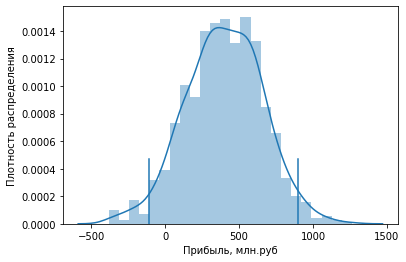

In [32]:

geo0_profit, geo0_interval, geo0_risk = bootstrap(pred0, geo0_y_valid)

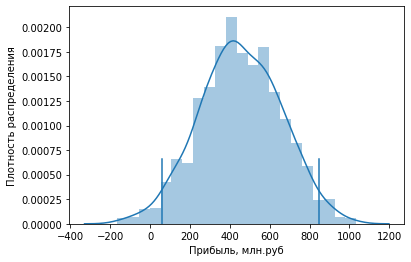

In [33]:
geo1_profit, geo1_interval, geo1_risk = bootstrap(pred1, geo1_y_valid)

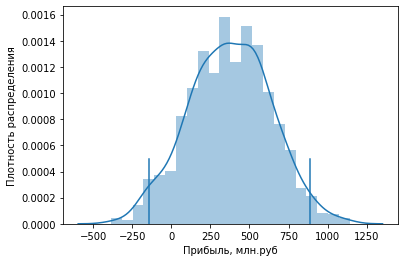

In [34]:
geo2_profit, geo2_interval, geo2_risk = bootstrap(pred2, geo2_y_valid)

In [35]:
print(
    f"Region 0: mean profit is {geo0_profit}, 95% interval is {geo0_interval}, loss risk is {geo0_risk:.2%}"
)
print(
    f"Region 1: mean profit is {geo1_profit}, 95% interval is {geo1_interval}, loss risk is {geo1_risk:.2%}"
)
print(
    f"Region 2: mean profit is {geo2_profit}, 95% interval is {geo2_interval}, loss risk is {geo2_risk:.2%}"
)

Region 0: mean profit is 399575478.05422974, 95% interval is (-110467895.33197214, 897460327.7178793), loss risk is 6.00%
Region 1: mean profit is 452048890.9064584, 95% interval is (61684479.654226795, 845340177.5073848), loss risk is 1.50%
Region 2: mean profit is 375009902.915329, 95% interval is (-144766727.30489266, 888390403.5342213), loss risk is 8.00%


Уже из графиков видно, что единственный регион у которого точка безубыточности не попадает в доверительный интервал - это регион 1. Таким образом, он единственный имеет риск убытков менее 2,5% (вероятность оказаться слева от 95% доверительного интервала не превышает 2,5%)

## Выводы

Были получены данные по запасам нефти в скважинах трёх регионов. Входные данные были нормированы и импользованы для обучения модели линейной регрессии. 

На основе прогнозов моделей методом `Bootstrap` мы отобрали 200 лучшых добычных скважин из случайных 500 разведочных. На основании полученного ряда прогнозов прибыли мы построили доверительный интервал прибыли и сделали оценку рисков. Наибольшим пригнозируемым значением прибыли и наименьшим риском характеризцуется регион 1: ожидаемая прибыль 452 млн. рублей при риске убытков 1,5%. 